In [1]:
from langgraph.graph import StateGraph, START, END 
from langchain_openai import ChatOpenAI 
from pydantic import BaseModel, Field 
from typing import List
from dotenv import load_dotenv 
load_dotenv()

True

In [2]:
llm = ChatOpenAI(model = "gpt-4o-mini")

#### **Schema for model**

In [3]:
class Section(BaseModel):
    name: str = Field(description="Name of section of the report")
    description: str = Field(description="Brief overview of the main topics and concepts to be covered in the section")

class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report")

In [ ]:
planner = llm.with_structured_output(Sections)

In [56]:
from langgraph.constants import Send
from typing import Annotated, List, TypedDict
import operator
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


C:\Users\hites\AppData\Local\Temp\ipykernel_17648\1429929837.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [57]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END) 

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

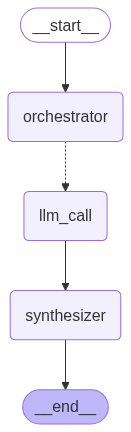

In [58]:
orchestrator_worker

In [59]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Computer Vision"})

Report Sections: sections=[Section(name='Introduction to Computer Vision', description='An overview of computer vision as a field of study, its significance, and its applications in various industries.'), Section(name='Fundamentals of Computer Vision', description='Discussion of the basic principles of computer vision including image processing, feature detection, and pattern recognition.'), Section(name='Machine Learning and Deep Learning in Computer Vision', description='An exploration of how machine learning algorithms, particularly deep learning techniques, are utilized in computer vision tasks such as image classification and object detection.'), Section(name='Key Applications of Computer Vision', description='Examination of the diverse applications of computer vision in fields such as healthcare, automotive, retail, and security.'), Section(name='Challenges and Limitations', description='An analysis of the current challenges facing computer vision technologies, including issues r

In [62]:
print(state["final_report"])

## Introduction to Computer Vision

Computer vision is a multidisciplinary field that enables machines to interpret and understand visual information from the world in a manner similar to humans. This area of study combines aspects of artificial intelligence, machine learning, and image processing to analyze and process images and videos. The significance of computer vision lies in its ability to transform raw visual data into actionable insights, allowing for automation, improved decision-making, and enhanced interaction between humans and machines.

The applications of computer vision span numerous industries, including:

1. **Healthcare:** In medical imaging, computer vision techniques assist in diagnosing diseases through the analysis of X-rays, MRIs, and other imaging modalities, enhancing accuracy and speed.

2. **Automotive:** In the realm of autonomous vehicles, computer vision systems are crucial for object detection, lane identification, and navigation, enabling cars to inter